<a href="https://colab.research.google.com/github/lovnishverma/Python-Getting-Started/blob/main/040_mnist_mlp_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST: multilayer perceptrons

Multilayer perceptrons (MLP) have been around for more than 25 years. They are suited to both regression and classification tasks. Here we will use a classic MLP to recognize handwritten digits (MNIST data set), as well as an MLP with a number of more recent twists.

## Data preparation

### Required imports

In [1]:
!pip install keras --upgrade --quiet

# Imports
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from scipy.sparse import issparse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00


### Obtaining the dataset

In Keras' datasets module we have a handle to the MNIST dataset we want to use in this notebook.  Download the training and test set for this data.

In [2]:
# Load Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Before we can start doing machine learning on the data, some preparations are required.  In this case, the data set is clean, which simplifies this step considerably.  Although it would be better to create a pipeline using the scikit-learn framework, we'll do the preparation by hand in this case.

### Transforming the data

Rather than use the 28 $\times$ 28 images as input directly, we reshape each image to a 784 array.

In [3]:
input_reshaper = FunctionTransformer(lambda x: x.reshape(x.shape[0], -1),
                                     validate=False)

Most training algorithms work better if the input is normalized between 0 and 1.

In [4]:
input_normalizer = FunctionTransformer(lambda x: x.astype(np.float32)/255.0,
                                       validate=True)

Both preprocessing steps can be combined into a single pipeline.

In [5]:
# Input Preprocessing
input_pipeline = Pipeline([
    ('reshaper', FunctionTransformer(lambda x: x.reshape(x.shape[0], -1), validate=False)),
    ('normalizer', FunctionTransformer(lambda x: x.astype(np.float32)/255.0, validate=True))
])

We can now fit and transform the training input, and transform the testing input.

In [6]:
x_train = input_pipeline.fit_transform(x_train)
x_test = input_pipeline.transform(x_test)

The output can be transformed to categorical data, i.e., one category for each digit, rather than a `uint8`. This is a one-hot encoding, so the output is now an array consisting of a single 1.0 value, and nine 0.0 values.  Before calling the `OneHotEncoder`, the output array has to be reshaped.  Note that the type of the output is now `float64`, which we can reduce to `float32` to reduce memory requirements and speed up computations.

In [7]:
output_reshaper = FunctionTransformer(lambda x: x.reshape(-1, 1),
                                      validate=False)

In [8]:
output_encoder = OneHotEncoder(categories='auto')

In [9]:
output_type_changer = FunctionTransformer(lambda x: x.astype(np.float32),
                                          validate=False)

In [10]:
# Output preprocessing - handle as dense array directly
output_pipeline = Pipeline([
    ('reshaper', FunctionTransformer(lambda x: x.reshape(-1, 1), validate=False)),
    ('binarizer', OneHotEncoder(sparse_output=False)),
    ('type_changer', FunctionTransformer(lambda x: x.astype(np.float32), validate=False))
])

Now the training output can be fit and transformed, and the testing output transformed accordingly.

In [11]:
y_train = output_pipeline.fit_transform(y_train)
y_test = output_pipeline.transform(y_test)

In [12]:
y_train.shape

(60000, 10)

In [13]:
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Note that the encoding of the output is now a sparse array.

### Validation set

In order to make this reproducible, we have to seed the random number generator.

In [14]:
# Train-validation split
np.random.seed(1234)

During the training, we will require a validation set, so we split the training data into two sets, one for actual training, the other for validation.  Note, we don't touch the test data set at all during the training process.  The default is using 75 % of the data for training, 25 % for validation. This function will also shuffle the data set prior to splitting (hence seeding the random number generator).

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [16]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((45000, 784), (15000, 784), (45000, 10), (15000, 10))

### Verification

Since we've done quite some transformations, let's verify whether we didn't mess up.

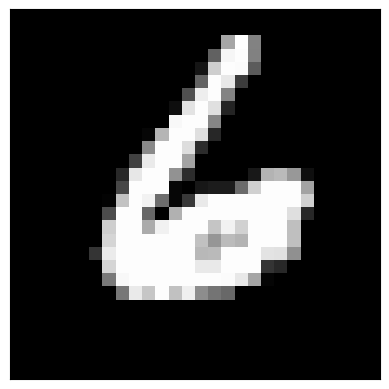

In [17]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0].reshape(28, 28), cmap='gray');

In [18]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Everything seems fine, input/output are as expected, and we can start doing some machine learning.

## Classic multilayer perceptron (MLP)

We start off training a classic multilayer neural network to familiarie ourselves with the keras framework.

### Required imports

In [19]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
import tensorflow as tf

### Model definition

We will create a fully connected neural network with 784 input units (28 $\times$ 28 pixels), two hidden layers with 512 units each, and an output layter with 10 units (ten categories, one per digit). For the two hidden layers, we will use a ReLU activation function, and a SoftMax for the output layer.

To obtain repeatable results, we need to seed the random number generator, taking into account that TensorFlow uses its own.

In [20]:

tf.random.set_seed(4958)

In [21]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Now we can can compile the model, specifying the loss function (categorical cross-entropy), the optimizer (SGD, Stochastic Gradient Descent), and the metrics (accuracy) we want to use.

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])



### Training

In [24]:
model_history = model.fit(x_train, y_train, batch_size=128, epochs=100, verbose=1, validation_data=(x_val, y_val))

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7462 - loss: 0.8869 - val_accuracy: 0.9214 - val_loss: 0.2711
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9315 - loss: 0.2401 - val_accuracy: 0.9427 - val_loss: 0.2004
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9501 - loss: 0.1763 - val_accuracy: 0.9533 - val_loss: 0.1640
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9610 - loss: 0.1394 - val_accuracy: 0.9589 - val_loss: 0.1412
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9679 - loss: 0.1148 - val_accuracy: 0.9631 - val_loss: 0.1260
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9738 - loss: 0.0968 - val_accuracy: 0.9657 - val_loss: 0.1158
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9775 - loss: 0.0827 - val_accuracy: 0.9675 - val_loss: 0.1085
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9811 - loss: 0.0714 - val_ac

Plot the history of the training process.

In [25]:
# Plot training history
def plot_history(network_history):
    plt.figure()
    plt.plot(network_history.history['loss'], label='Train Loss')
    plt.plot(network_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(network_history.history['accuracy'], label='Train Accuracy')
    plt.plot(network_history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

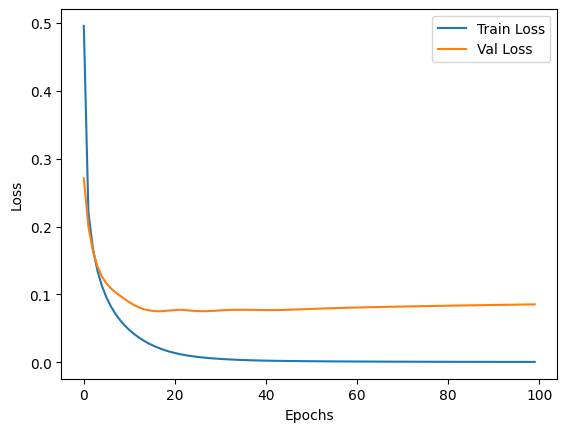

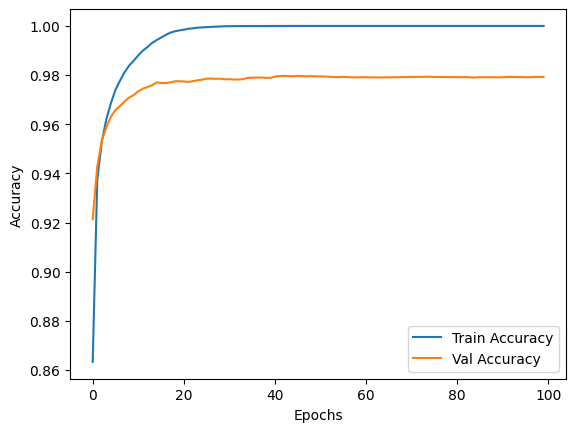

In [26]:
plot_history(model_history)

Let's compare the performance of the model on the training, validation and test set.

In [27]:
# Evaluate
print("Train accuracy:")
model.evaluate(x_train, y_train)

Train accuracy:
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 4.7325e-04


[0.00048210518434643745, 1.0]

In [28]:
print("Validation accuracy:")
model.evaluate(x_val, y_val)

Validation accuracy:
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9791 - loss: 0.0791


[0.08529714494943619, 0.9792666435241699]

In [29]:
print("Test accuracy:")
model.evaluate(x_test, y_test)

Test accuracy:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9758 - loss: 0.0964


[0.08112300932407379, 0.9799000024795532]

### Save model

We can save the model as an HDF5 file so that it can later be reloaded.

In [30]:
model.save('mnist_mlp.h5')

### Dropout layers

In order to reduce overfitting, drop out can be applied, i.e., randomly setting input values to 0 during training. We add a drop-out layer between the hidden layers, and between the last hidden layer and the output layer.

In [31]:
np.random.seed(1234)

In [32]:
dropout_model = Sequential()
dropout_model.add(Dense(512, activation='relu', input_shape=(784,)))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(512, activation='relu'))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(10, activation='softmax'))

In [33]:
dropout_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
dropout_model.compile(loss='categorical_crossentropy', optimizer=SGD(),
                      metrics=['accuracy'])

In [35]:
dropout_model_history = dropout_model.fit(x_train, y_train, batch_size=128,
                                          epochs=100, verbose=1,
                                          validation_data=(x_val, y_val))

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4826 - loss: 1.7965 - val_accuracy: 0.8442 - val_loss: 0.6828
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8161 - loss: 0.6776 - val_accuracy: 0.8773 - val_loss: 0.4545
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8566 - loss: 0.4969 - val_accuracy: 0.8939 - val_loss: 0.3822
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8762 - loss: 0.4287 - val_accuracy: 0.9013 - val_loss: 0.3449
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8868 - loss: 0.3916 - val_accuracy: 0.9081 - val_loss: 0.3189
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8944 - loss: 0.3609 - val_accuracy: 0.9130 - val_loss: 0.3006
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9003 - loss: 0.3392 - val_accuracy: 0.9182 - val_loss: 0.2854
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9080 - loss: 0.3169 - val_acc

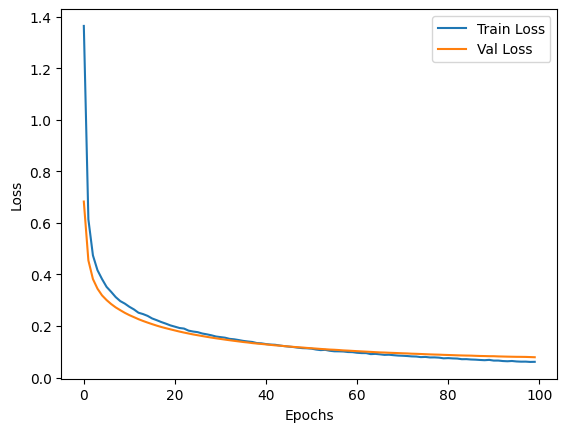

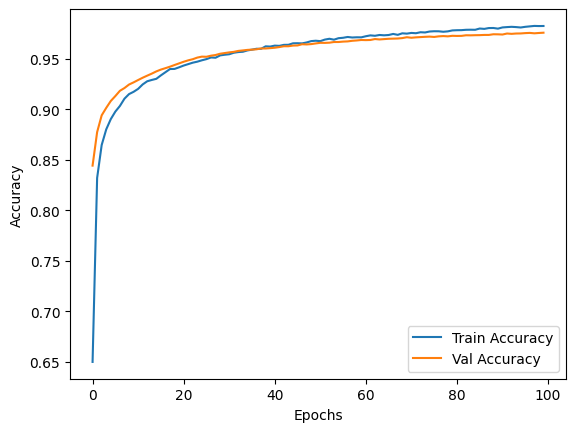

In [36]:
plot_history(dropout_model_history)

Again, let's compare the performance of the model on the training, validation and test set.

In [37]:
# Evaluate Dropout Model
dropout_model.evaluate(x_train, y_train)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9891 - loss: 0.0411


[0.04086528718471527, 0.9891111254692078]

In [38]:
dropout_model.evaluate(x_val, y_val)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9760 - loss: 0.0759


[0.07900550961494446, 0.9756666421890259]

In [39]:
dropout_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9745 - loss: 0.0864


[0.07336520403623581, 0.9779999852180481]

In [40]:
dropout_model.save('mnist_mlp_dropout.h5')

## Understanding the model

We should try to gain some insight into the model.  There are several ways to do this.

In [41]:
# Confusion matrix
analysis_model = model

Replace `model` by `dropout_model` in case you want to analyze the latter.

### Required imports

In [42]:
import itertools
import pandas as pd
import seaborn as sns

### Confusion matrix

The model produces some classification errors, it would be interesting to see the type of errors.  Computing a confustion matrix is useful for that prupose.

In [44]:
pred_probs = analysis_model.predict(x_test)
y_pred_classes = np.argmax(pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [45]:
y_true_classes = np.argmax(y_test, axis=1)

In [46]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

From the confusion matrix, it is clear that, e.g., 2 and 7 get confused, as well as 4 and 9.  Given the data, that should come as no surprise.

In [49]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    log1p_cm = np.log1p(cm)
    if normalize:
        cm = cm.astype(np.float32) / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(log1p_cm, interpolation='nearest', cmap=cmap)
    ax.set_xticks(classes)
    ax.set_yticks(classes)

    fmt = '{:.2f}' if normalize else '{}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, fmt.format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

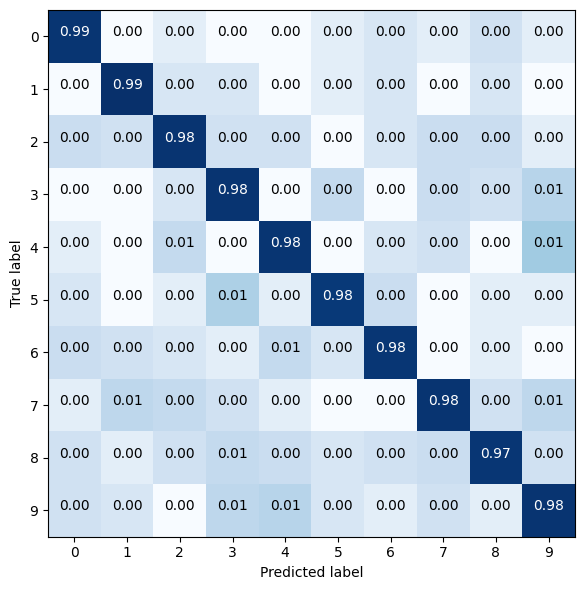

In [50]:
plot_confusion_matrix(cm, classes=range(10), normalize=True)

### Sensitivity to initial conditions

How sensitive is the training process to the initial values of the model?  Let's train and evaluate the model several times, and observe the outcomes.

In [51]:
# Sensitivity to initial conditions
np.random.seed(1234)
tf.random.set_seed(459845)
names = ('train', 'val', 'test')
inputs = (x_train, x_val, x_test)
outputs = (y_train, y_val, y_test)
losses, accuracies = {n: [] for n in names}, {n: [] for n in names}

for i in range(10):
    print(f"Training model {i+1}/10")
    mod = Sequential([
        Dense(512, activation='relu', input_shape=(784,)),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    mod.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
    mod.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(x_val, y_val))
    for name, X, Y in zip(names, inputs, outputs):
        loss, acc = mod.evaluate(X, Y, verbose=0)
        losses[name].append(loss)
        accuracies[name].append(acc)
    mod.save(f'mnist_mlp_{i+1:02d}.h5')

Training model 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model 2/10


Training model 3/10


Training model 4/10


Training model 5/10


Training model 6/10


Training model 7/10


Training model 8/10


Training model 9/10


Training model 10/10


Losses and accuracies are quite reproducible across runs with different initializations of the model.

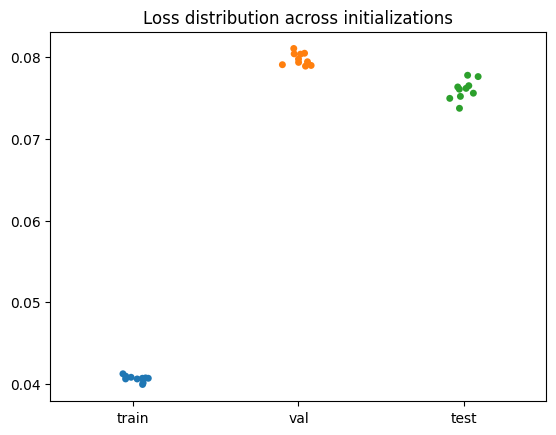

In [52]:
# Visualize reproducibility
sns.stripplot(data=pd.DataFrame(losses), jitter=0.1)
plt.title("Loss distribution across initializations")
plt.show()

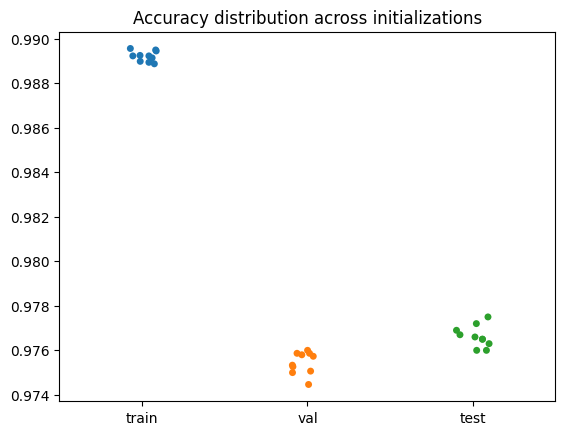

In [53]:
sns.stripplot(data=pd.DataFrame(accuracies), jitter=0.1)
plt.title("Accuracy distribution across initializations")
plt.show()